  0.

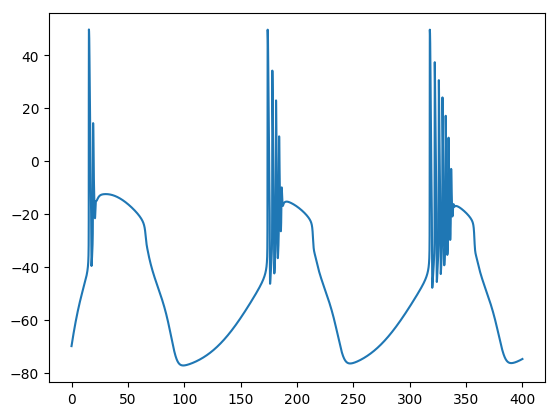

239486 seconds (116.99 k allocations: 7.634 MB)


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f30270d8890>

In [1]:
# Loads packages
using PyPlot

# Model from liu et al., 1998.

# gating functions
boltz(V::Float64,A::Float64,B::Float64) = 1/(1 + exp((V+A)/B))
tauX(V::Float64,A::Float64,B::Float64,D::Float64,E::Float64) = A - B/(1+exp((V+D)/E))
mNainf(V::Float64) = boltz(V,25.5,-5.29)
taumNa(V::Float64) = tauX(V,1.32,1.26,120.,-25.)
hNainf(V::Float64) = boltz(V,48.9,5.18)
tauhNa(V::Float64) = (0.67/(1+exp((V+62.9)/-10.0)))*(1.5 + 1/(1+exp((V+34.9)/3.6)))
mCaTinf(V::Float64) = boltz(V,27.1,-7.2)
taumCaT(V::Float64) = tauX(V,21.7,21.3,68.1,-20.5)
hCaTinf(V::Float64) = boltz(V,32.1,5.5)
tauhCaT(V::Float64) = tauX(V,105.,89.8,55.,-16.9)
mCaSinf(V::Float64) = boltz(V,33.,-8.1)
taumCaS(V::Float64) = 1.4 + (7/((exp((V+27)/10))+(exp((V+70)/-13))))
hCaSinf(V::Float64) = boltz(V,60.,6.2)
tauhCaS(V::Float64) = 60 + (150/((exp((V+55)/9))+(exp((V+65)/-16))))
mAinf(V::Float64) = boltz(V,27.2,-8.7)
taumA(V::Float64) = tauX(V,11.6,10.4,32.9,-15.2)
hAinf(V::Float64) = boltz(V,56.9,4.9)
tauhA(V::Float64) = tauX(V,38.6,29.2,38.9,-26.5)
mKCainf(V::Float64,Ca::Float64) = (Ca/(Ca+3))*(1/(1+exp((V+28.3)/-12.6)))
taumKCa(V::Float64) = tauX(V,90.3,75.1,46.,-22.7)
mKdinf(V::Float64) = boltz(V,12.3,-11.8)
taumKd(V::Float64) = tauX(V,7.2,6.4,28.3,-19.2)
mHinf(V::Float64) = boltz(V,70.,6.)
taumH(V::Float64) = tauX(V,272.,-1499.,42.2,-8.73)

function dV(C::Float64, V::Float64, mNa::Float64, hNa::Float64, mCaT::Float64, hCaT::Float64, mCaS::Float64, hCaS::Float64, mA::Float64, hA::Float64, mKCa::Float64, mKd::Float64, mH::Float64, Ca::Float64, Iapp::Float64,gCaTOT::Float64)
  (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaTOT*gCaT*mCaT^3*hCaT*(V-VCa) -gCaTOT*gCaS*mCaS^3*hCaS*(V-VCa) -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) -gleak*(V-Vleak) + Iapp)
end

dmNa(V::Float64,mNa::Float64) = (dt)*((1/taumNa(V))*(mNainf(V) - mNa))
dhNa(V::Float64,hNa::Float64) = (dt)*((1/tauhNa(V))*(hNainf(V) - hNa))
dmCaT(V::Float64,mCaT::Float64) = (dt)*((1/taumCaT(V))*(mCaTinf(V) - mCaT))
dhCaT(V::Float64,hCaT::Float64) = (dt)*((1/tauhCaT(V))*(hCaTinf(V) - hCaT))
dmCaS(V::Float64,mCaS::Float64) = (dt)*((1/taumCaS(V))*(mCaSinf(V) - mCaS))
dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
dmA(V::Float64,mA::Float64) = (dt)*((1/taumA(V))*(mAinf(V) - mA))
dhA(V::Float64,hA::Float64) = (dt)*((1/tauhA(V))*(hAinf(V) - hA))
dmKCa(V::Float64,Ca::Float64,mKCa::Float64) = (dt)*((1/taumKCa(V))*(mKCainf(V,Ca) - mKCa))
dmKd(V::Float64,mKd::Float64) = (dt)*((1/taumKd(V))*(mKdinf(V) - mKd))
dmH(V::Float64,mH::Float64) = (dt)*((1/taumH(V))*(mHinf(V) - mH))
dCa(V::Float64,mCaT::Float64,hCaT::Float64,mCaS::Float64,hCaS::Float64,Ca::Float64) = (dt)*(-0.94*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)

function simulateSTG(Iapp::Float64,gCaTOT::Float64)
  V::Float64=-70.
  Vtemp::Float64=copy(V)
  Ca::Float64=0.5
  Catemp::Float64=copy(Ca)
  mNa::Float64=mNainf(V)
  hNa::Float64=hNainf(V)
  mCaT::Float64=mCaTinf(V)
  hCaT::Float64=hCaTinf(V)
  mCaS::Float64=mCaSinf(V)
  hCaS::Float64=hCaSinf(V)
  mA::Float64=mAinf(V)
  hA::Float64=hAinf(V)
  mKCa::Float64=mKCainf(V,Ca)
  mKd::Float64=mKdinf(V)
  mH::Float64=mHinf(V)

  VV = zeros(Tdt)

  for z = 1:Tdt
    V += dV(C, Vtemp, mNa, hNa, mCaT, hCaT, mCaS, hCaS, mA, hA, mKCa, mKd, mH, Catemp, Iapp,gCaTOT)
    Ca += dCa(Vtemp,mCaT,hCaT,mCaS,hCaS,Catemp)

    mNa += dmNa(Vtemp,mNa)
    hNa += dhNa(Vtemp,hNa)
    mCaT += dmCaT(Vtemp,mCaT)
    hCaT += dhCaT(Vtemp,hCaT)
    mCaS += dmCaS(Vtemp,mCaS)
    hCaS += dhCaS(Vtemp,hCaS)
    mA += dmA(Vtemp,mA)
    hA += dhA(Vtemp,hA)
    mKd += dmKd(Vtemp,mKd)
    mKCa += dmKCa(Vtemp,Catemp,mKCa)
    mH += dmH(Vtemp,mH)

    VV[z] = copy(V)
    Vtemp = copy(V)
    Catemp = copy(Ca)
  end

  return VV
end





# Simulation parameters
const T = 400
const dt = 0.001
const Tdt = convert(Int64,T/dt)
const t = linspace(dt,T,Tdt)

# Model parameters
const z = 1

const VNa = 50
const VK = -80
const VCa = 80
const VH = -20
const Vleak = -50
const gleak = 0.01*z
const gNa = 800*z
const gCaT = 3*z
const gCaS = 8*z
const gA = 50*z
const gKd = 90*z
const gKCa = 60*z
const gH = z*0.1
const C=1.

# Simulation (Iapp,gCaTOT), where gCaTOT uniformly scales the calcium conductance vector
@time yy1 = simulateSTG(0.1,2.0)
plot(t,yy1,"-")









